In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parent  # parent of notebooks/
sys.path.append(str(project_root))

from src.data_processing import TimeFeaturesExtractor, NumericAggregator, CategoricalTopKAggregator, FeatureEngineeringPipeline, WoETransformer
from src.utils.helpers import load_raw_data
from src.config.config import Config

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np



In [2]:
# Load the raw CSV file
data_path = Config.DATA_DIR / "raw"/"data.csv"
df = load_raw_data(data_path)
df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [3]:

time_cols = [ "txn_datetime","txn_hour", "txn_day", "txn_month", "txn_year"]
time_extractor = TimeFeaturesExtractor(datetime_col='TransactionStartTime')
df_time = time_extractor.fit_transform(df)
df_time[time_cols].head()



2025-12-15 18:08:31,199 - INFO - TimeFeaturesExtractor fit completed.
2025-12-15 18:08:31,199 - INFO - Extracting time features...
2025-12-15 18:08:31,305 - INFO - Time features extracted.


,txn_datetime,txn_hour,txn_day,txn_month,txn_year
0,2018-11-15 02:18:49+00:00,2,15,11,2018
1,2018-11-15 02:19:08+00:00,2,15,11,2018
2,2018-11-15 02:44:21+00:00,2,15,11,2018
3,2018-11-15 03:32:55+00:00,3,15,11,2018
4,2018-11-15 03:34:21+00:00,3,15,11,2018


In [4]:

numeric_agg = NumericAggregator(group_col='CustomerId', numeric_cols=['Amount'])
df_numeric = numeric_agg.fit_transform(df_time)
df_numeric.head(10)




2025-12-15 18:08:31,317 - INFO - NumericAggregator fit completed.
2025-12-15 18:08:31,317 - INFO - Aggregating numeric columns...
2025-12-15 18:08:31,331 - INFO - Numeric aggregation completed.


,Amount_sum,Amount_mean,Amount_count,Amount_std,CustomerId
0,-10000.0,-10000.000000,1,NaN,CustomerId_1
1,-10000.0,-10000.000000,1,NaN,CustomerId_10
2,20000.0,4000.000000,5,6558.963333,CustomerId_1001
3,4225.0,384.090909,11,560.498966,CustomerId_1002
4,20000.0,3333.333333,6,6030.478146,CustomerId_1003
5,2000.0,2000.000000,1,NaN,CustomerId_1004
6,48800.0,5422.222222,9,5983.681513,CustomerId_1005
7,1000.0,1000.000000,1,NaN,CustomerId_1006
8,28000.0,28000.000000,1,NaN,CustomerId_1007
9,20000.0,10000.000000,2,0.000000,CustomerId_1008


In [5]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col != 'TransactionStartTime']

# Initialize the aggregator
cat_agg = CategoricalTopKAggregator(group_col='CustomerId', 
                                    categorical_cols=categorical_columns, 
                                    top_k=3)

# Fit and transform
df_categorical = cat_agg.fit(df).transform(df)

df_categorical.head()


2025-12-15 18:08:31,412 - INFO - CategoricalTopKAggregator fit completed.
2025-12-15 18:08:31,412 - INFO - Aggregating top-K categorical features...
2025-12-15 18:08:31,909 - INFO - Top-K categorical aggregation completed.


,CustomerId,transactionid_transactionid_76871_ratio,transactionid_transactionid_73770_ratio,transactionid_transactionid_26203_ratio,batchid_batchid_67019_ratio,batchid_batchid_51870_ratio,batchid_batchid_113893_ratio,accountid_accountid_4841_ratio,accountid_accountid_4249_ratio,accountid_accountid_4840_ratio,...,providerid_providerid_5_ratio,productid_productid_6_ratio,productid_productid_3_ratio,productid_productid_10_ratio,productcategory_financial_services_ratio,productcategory_airtime_ratio,productcategory_utility_bill_ratio,channelid_channelid_3_ratio,channelid_channelid_2_ratio,channelid_channelid_5_ratio
0,CustomerId_1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0
1,CustomerId_10,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0
2,CustomerId_1001,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,0.0,0.000000,...,0.200000,0.400000,0.000000,0.400000,0.600000,0.400000,0.0,0.600000,0.400000,0.0
3,CustomerId_1002,0.0,0.0,0.0,0.0,0.0,0.0,0.545455,0.0,0.000000,...,0.454545,0.545455,0.363636,0.000000,0.545455,0.454545,0.0,0.454545,0.545455,0.0
4,CustomerId_1003,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.166667,...,0.166667,0.333333,0.166667,0.333333,0.500000,0.500000,0.0,0.666667,0.333333,0.0


In [6]:

pipeline = FeatureEngineeringPipeline(
    datetime_col='TransactionStartTime',
    group_col='CustomerId',
    numeric_cols=['Amount'],
    categorical_cols=categorical_columns,
    top_k=3  # default is 3, but you can increase
)


# Fit and transform
customer_features_df = pipeline.fit_transform(df)

# Display result
customer_features_df.head()


2025-12-15 18:08:31,932 - INFO - Fitting FeatureEngineeringPipeline...
2025-12-15 18:08:31,935 - INFO - TimeFeaturesExtractor fit completed.
2025-12-15 18:08:31,935 - INFO - Extracting time features...
2025-12-15 18:08:32,035 - INFO - Time features extracted.
2025-12-15 18:08:32,043 - INFO - NumericAggregator fit completed.
2025-12-15 18:08:32,045 - INFO - Aggregating numeric columns...
2025-12-15 18:08:32,052 - INFO - Numeric aggregation completed.
2025-12-15 18:08:32,126 - INFO - CategoricalTopKAggregator fit completed.
2025-12-15 18:08:32,126 - INFO - Aggregating top-K categorical features...
2025-12-15 18:08:32,676 - INFO - Top-K categorical aggregation completed.
2025-12-15 18:08:32,682 - INFO - FeatureEngineeringPipeline fit completed.
2025-12-15 18:08:32,690 - INFO - Transforming data using FeatureEngineeringPipeline...
2025-12-15 18:08:32,690 - INFO - Extracting time features...
2025-12-15 18:08:32,790 - INFO - Time features extracted.
2025-12-15 18:08:32,790 - INFO - Aggregati

,Amount_sum,Amount_mean,Amount_count,Amount_std,transactionid_transactionid_76871_ratio,transactionid_transactionid_73770_ratio,transactionid_transactionid_26203_ratio,batchid_batchid_67019_ratio,batchid_batchid_51870_ratio,batchid_batchid_113893_ratio,...,productid_productid_6_ratio,productid_productid_3_ratio,productid_productid_10_ratio,productcategory_financial_services_ratio,productcategory_airtime_ratio,productcategory_utility_bill_ratio,channelid_channelid_3_ratio,channelid_channelid_2_ratio,channelid_channelid_5_ratio,CustomerId
0,-0.066891,-0.153364,-0.253459,-0.095504,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0,CustomerId_1
1,-0.066891,-0.153364,-0.253459,-0.095504,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.0,CustomerId_10
2,-0.055849,-0.069870,-0.212186,-0.083421,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.000000,0.400000,0.600000,0.400000,0.0,0.600000,0.400000,0.0,CustomerId_1001
3,-0.061655,-0.091435,-0.150278,-0.145414,0.0,0.0,0.0,0.0,0.0,0.0,...,0.545455,0.363636,0.000000,0.545455,0.454545,0.0,0.454545,0.545455,0.0,CustomerId_1002
4,-0.055849,-0.073846,-0.201868,-0.088882,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.166667,0.333333,0.500000,0.500000,0.0,0.666667,0.333333,0.0,CustomerId_1003


In [7]:
# List all columns
print(customer_features_df.columns)


Index(['Amount_sum', 'Amount_mean', 'Amount_count', 'Amount_std',
       'transactionid_transactionid_76871_ratio',
       'transactionid_transactionid_73770_ratio',
       'transactionid_transactionid_26203_ratio',
       'batchid_batchid_67019_ratio', 'batchid_batchid_51870_ratio',
       'batchid_batchid_113893_ratio', 'accountid_accountid_4841_ratio',
       'accountid_accountid_4249_ratio', 'accountid_accountid_4840_ratio',
       'subscriptionid_subscriptionid_3829_ratio',
       'subscriptionid_subscriptionid_4429_ratio',
       'subscriptionid_subscriptionid_1372_ratio',
       'customerid_customerid_7343_ratio', 'customerid_customerid_3634_ratio',
       'customerid_customerid_647_ratio', 'currencycode_ugx_ratio',
       'providerid_providerid_4_ratio', 'providerid_providerid_6_ratio',
       'providerid_providerid_5_ratio', 'productid_productid_6_ratio',
       'productid_productid_3_ratio', 'productid_productid_10_ratio',
       'productcategory_financial_services_ratio',
  

In [8]:
customer_features_df.dtypes

Amount_sum                                  float64
Amount_mean                                 float64
Amount_count                                float64
Amount_std                                  float64
transactionid_transactionid_76871_ratio     float64
transactionid_transactionid_73770_ratio     float64
transactionid_transactionid_26203_ratio     float64
batchid_batchid_67019_ratio                 float64
batchid_batchid_51870_ratio                 float64
batchid_batchid_113893_ratio                float64
accountid_accountid_4841_ratio              float64
accountid_accountid_4249_ratio              float64
accountid_accountid_4840_ratio              float64
subscriptionid_subscriptionid_3829_ratio    float64
subscriptionid_subscriptionid_4429_ratio    float64
subscriptionid_subscriptionid_1372_ratio    float64
customerid_customerid_7343_ratio            float64
customerid_customerid_3634_ratio            float64
customerid_customerid_647_ratio             float64
currencycode

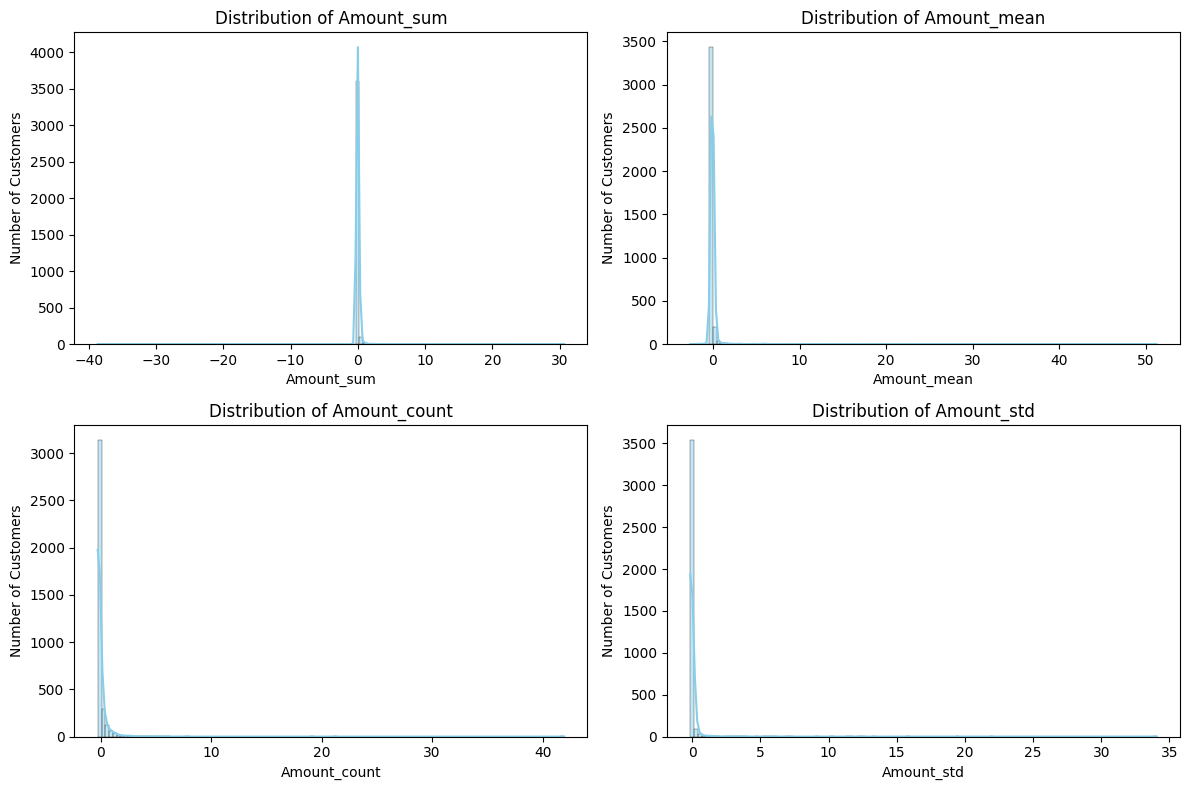

In [9]:
%matplotlib inline


numeric_features = [col for col in customer_features_df.columns if 'Amount' in col]

# Set up subplots
n_cols = 2  # number of columns in the subplot grid
n_rows = (len(numeric_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot each numeric feature
for i, col in enumerate(numeric_features):
    sns.histplot(customer_features_df[col], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Number of Customers")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


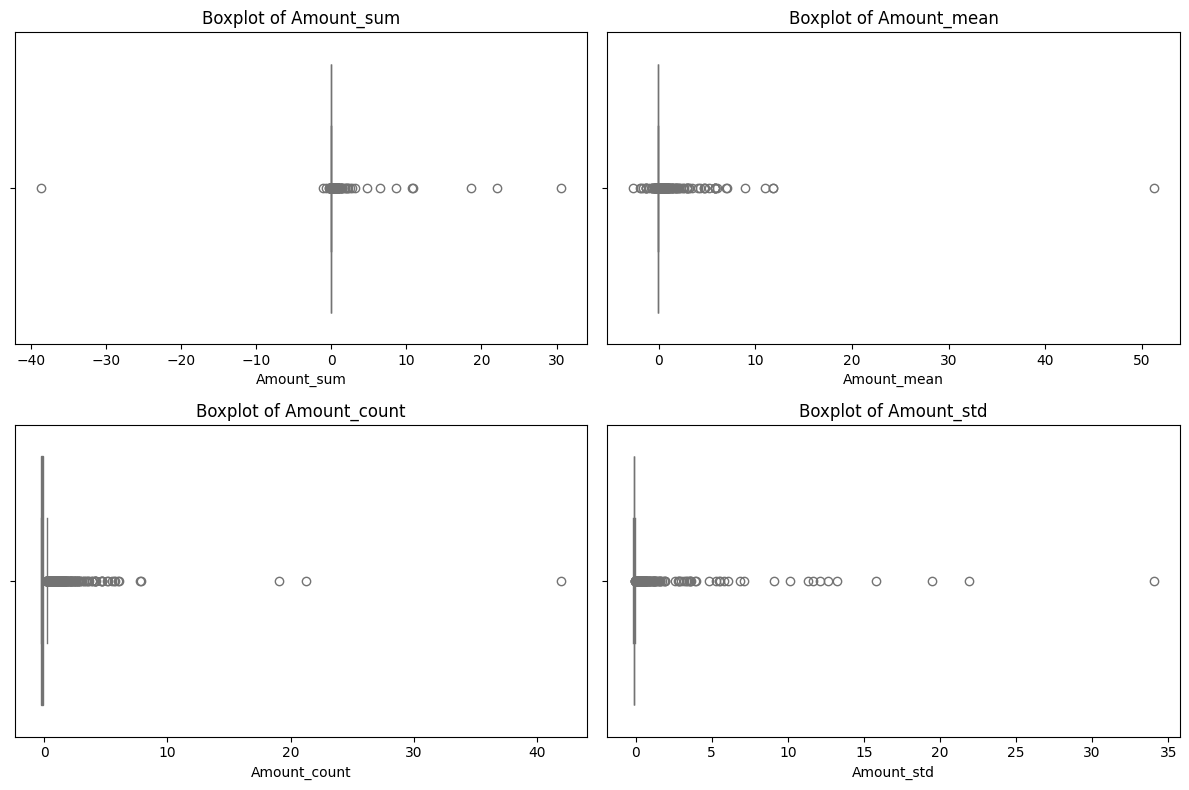

In [10]:


# Set up subplots
n_cols = 2  # number of columns in the subplot grid
n_rows = (len(numeric_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot each numeric feature as a boxplot
for i, col in enumerate(numeric_features):
    sns.boxplot(x=customer_features_df[col], color='lightgreen', ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


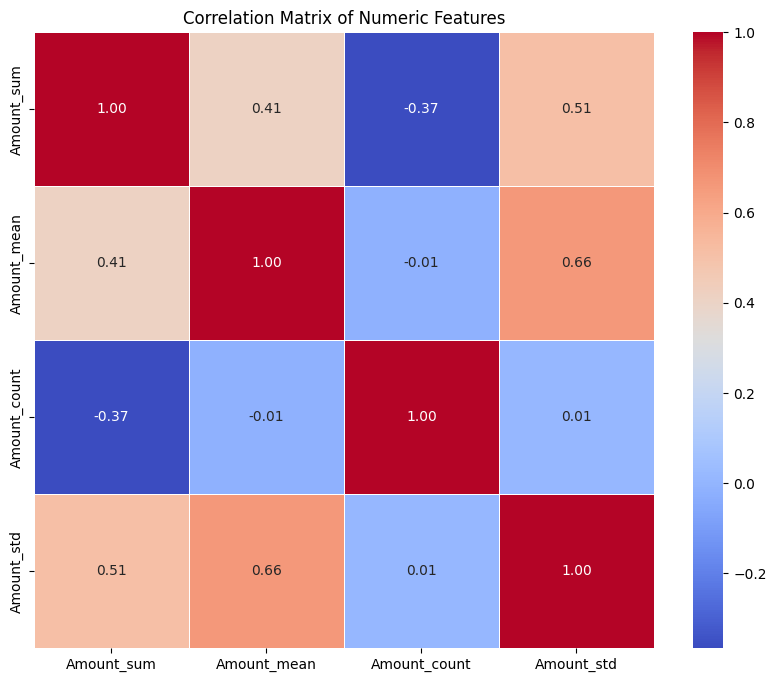

In [11]:
plt.figure(figsize=(10,8))
corr = customer_features_df[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


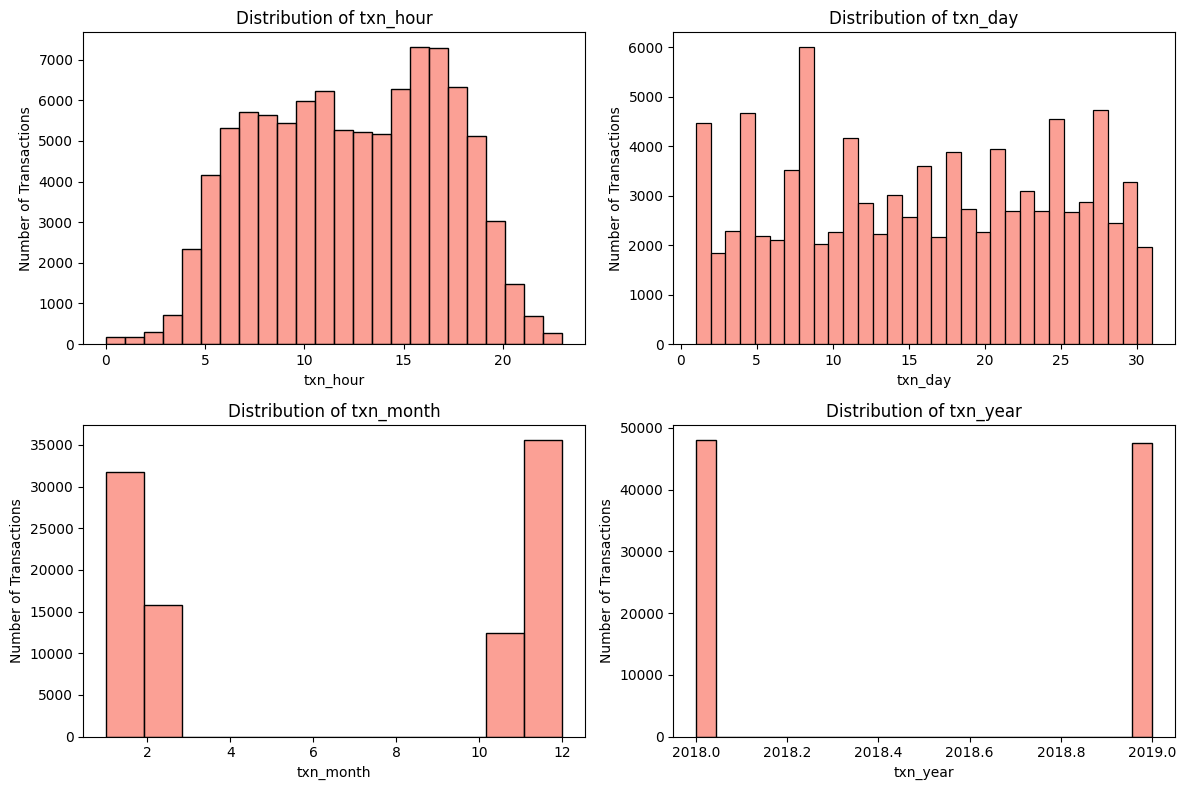

In [12]:


time_cols = ['txn_hour', 'txn_day', 'txn_month', 'txn_year']

# Set up subplots
n_cols = 2  # number of columns
n_rows = (len(time_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot each time feature
for i, col in enumerate(time_cols):
    bins = 24 if col == 'txn_hour' else 31 if col == 'txn_day' else 12 if col == 'txn_month' else 'auto'
    sns.histplot(df_time[col], bins=bins, kde=False, color='salmon', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Number of Transactions")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


2025-12-15 18:08:35,219 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-15 18:08:35,224 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


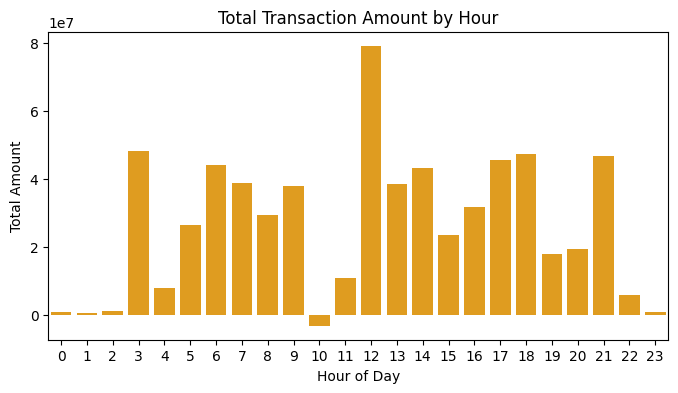

In [13]:
hourly = df_time.groupby('txn_hour')['Amount'].sum()
plt.figure(figsize=(8,4))
sns.barplot(x=hourly.index, y=hourly.values, color='orange')
plt.title("Total Transaction Amount by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Total Amount")
plt.show()


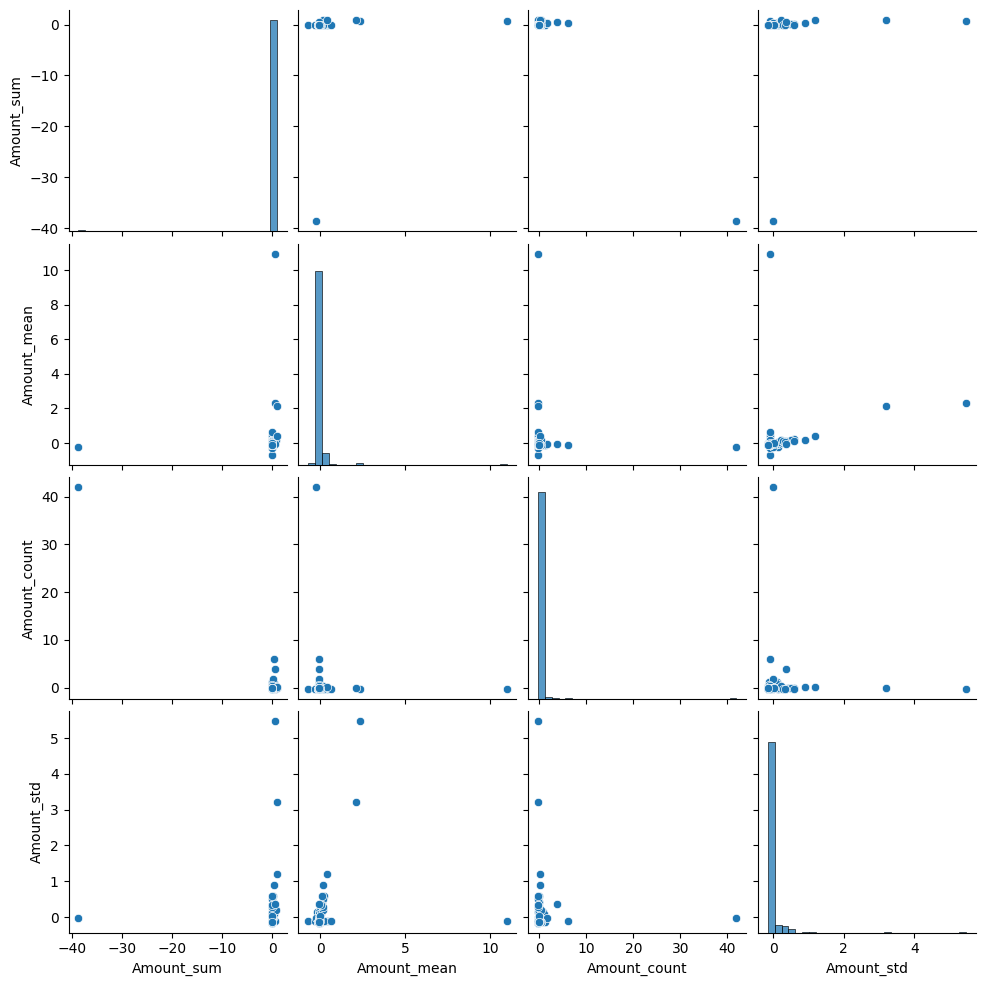

In [14]:
sns.pairplot(customer_features_df[numeric_features].sample(200))  # sample for speed
plt.show()


2025-12-15 18:08:36,700 - INFO - Extracting time features...
2025-12-15 18:08:36,813 - INFO - Time features extracted.
2025-12-15 18:08:36,865 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-15 18:08:36,897 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


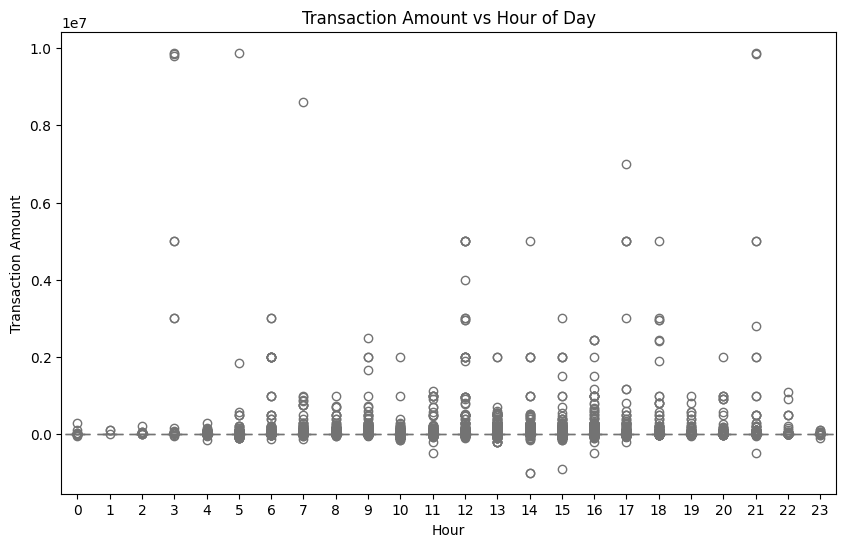

In [15]:
df_time = pipeline.time_extractor.transform(df)  # raw transactions with time features

plt.figure(figsize=(10,6))
sns.boxplot(x='txn_hour', y='Amount', data=df_time, color='lightgreen')
plt.title("Transaction Amount vs Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Transaction Amount")
plt.show()



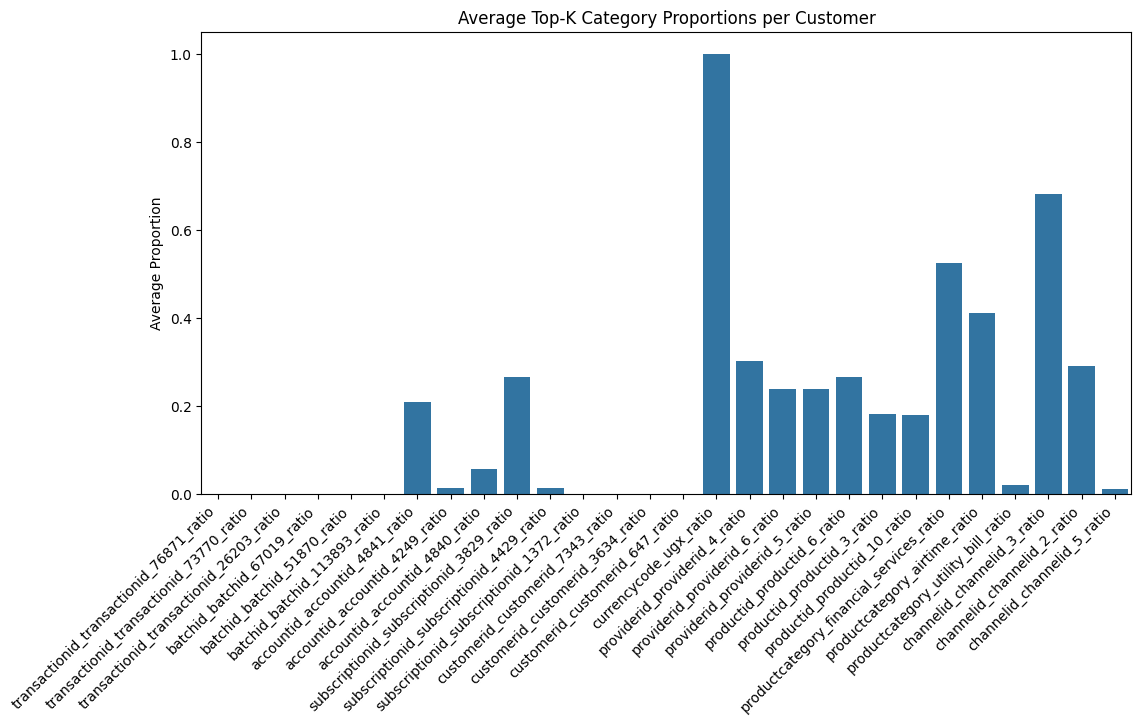

In [16]:


# Example: categorical proportion columns
cat_cols = [col for col in customer_features_df.columns if '_ratio' in col]

plt.figure(figsize=(12,6))
sns.barplot(
    x=cat_cols,
    y=customer_features_df[cat_cols].mean().values
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Proportion")
plt.title("Average Top-K Category Proportions per Customer")
plt.show()


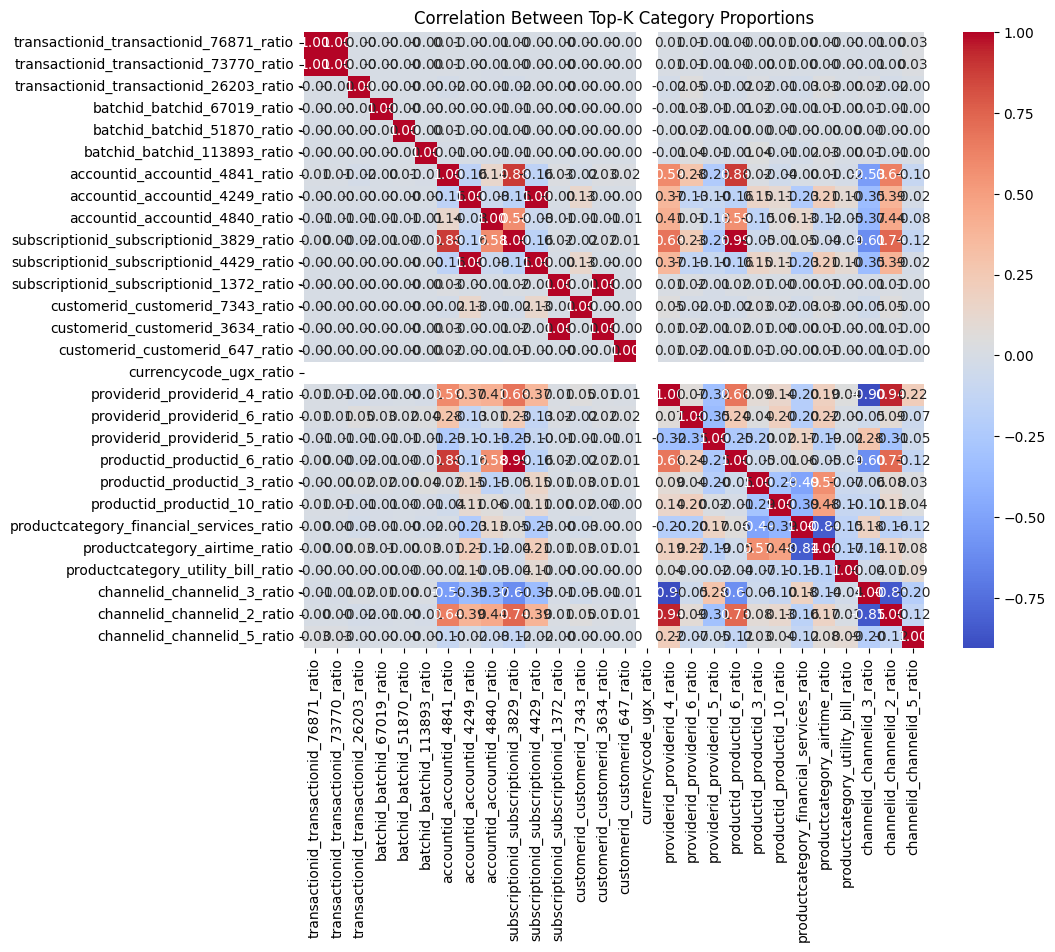

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(
    customer_features_df[cat_cols].corr(),
    annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Correlation Between Top-K Category Proportions")
plt.show()


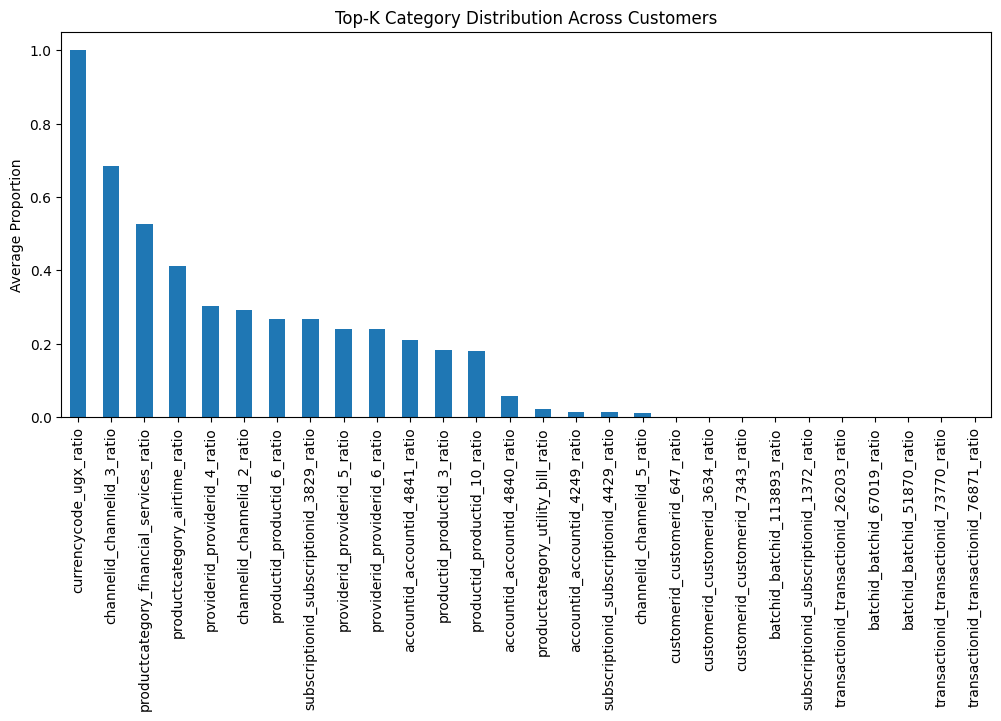

In [18]:
category_summary = customer_features_df[cat_cols].mean().sort_values(ascending=False)
category_summary.plot(kind='bar', stacked=True, figsize=(12,5))
plt.ylabel("Average Proportion")
plt.title("Top-K Category Distribution Across Customers")
plt.show()


In [19]:
target_col = "FraudResult"
id_cols = {
    "transactionid",
    "batchid",
    "accountid",
    "subscriptionid",
    "customerid",
    "productid"
}

categorical_features = [
    c for c in categorical_columns
    if c.lower() not in id_cols
]

X = df[categorical_features].copy()
X = X.fillna("MISSING").astype(str)

y = df[target_col]

woe = WoETransformer(categorical_features)
X_woe = woe.fit_transform(X, y)


2025-12-15 18:08:38,715 - INFO - Fitting WoETransformer...
c:\Users\amare\Documents\KAIM\week-4\credit-risk-model\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\amare\Documents\KAIM\week-4\credit-risk-model\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\amare\Documents\KAIM\week-4\credit-risk-model\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
2025-12-15 18:08:38,819 - INFO - WoETransformer fit completed. Valid features: ['ChannelId']
2025-12-15 18:08:38,819 - INFO - Transforming data using WoETransformer...
c:\Users\amare\Documents\KAIM\week-4\credit-risk-model\.venv\Lib\site-packages\xverse\transformer\_woe.py:310: FutureWarning: Downcasting

In [20]:
X_woe.shape


(95662, 1)

In [21]:
print(X_woe.head())


   ChannelId_WOE
0       0.472374
1      -2.709038
2       0.472374
3       0.472374
4      -2.709038


In [22]:
woe.valid_features_


['ChannelId']

In [23]:
woe.iv_


,Variable_Name,Information_Value
0,ChannelId,1.172958


In [24]:

pd.concat([X_woe, y], axis=1).groupby("FraudResult").mean()


,ChannelId_WOE
FraudResult,
0,-0.765649
1,0.407309


After applying WoE encoding, only the ChannelId feature exhibited non-zero Information Value. Other categorical features were excluded automatically due to low variability or zero predictive power with respect to the fraud target. This behavior is expected in WoE-based feature selection.

In [25]:

# Original path: Config.DATA_DIR / "processed" / "customer_features.csv"
output_path = Config.DATA_DIR/ "processed" / "customer_features.csv"

# Make sure the parent folder exists
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save CSV
customer_features_df.to_csv(output_path, index=False)
print(f"Saved customer features to: {output_path}")
print(f"Shape: {customer_features_df.shape}")


Saved customer features to: C:\Users\amare\Documents\KAIM\week-4\credit-risk-model\data\processed\customer_features.csv
Shape: (3742, 33)
